In [1]:
# Step 1: See what folders actually exist right now
!ls -la

total 12
drwxr-xr-x 3 root root 4096 Dec  5 12:46 .
drwxr-xr-x 5 root root 4096 Dec  5 12:45 ..
drwxr-xr-x 2 root root 4096 Dec  5 12:46 .virtual_documents


In [2]:
# Step 2: Find the real folder name (you’ll see something like "disease-22" or "dataset")
# Most common cases:
!ls -la disease-22/dataset      # ← try this first
# or
!ls -la dataset                 # ← if this works, use this

ls: cannot access 'disease-22/dataset': No such file or directory
ls: cannot access 'dataset': No such file or directory


In [13]:
# Animal Disease Image Classifier using ResNet50
# ------------------------------------------------
# This script trains a deep learning model to classify animal diseases
# using transfer learning and fine-tuning.

# Steps:
# 1. Load and preprocess dataset
# 2. Train frozen base model (ResNet50)
# 3. Fine-tune last layers
# 4. Evaluate and save final model

# 1. Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import os
import pandas as pd
from pathlib import Path



from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# 2. Performance Optimization
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)


# # 3. Dataset Path


DATASET_ROOT = "/kaggle/input/disease-22/dataset"

TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
VAL_DIR   = os.path.join(DATASET_ROOT, "val")
TEST_DIR  = os.path.join(DATASET_ROOT, "test")

# Optional: To verify dataset paths
print("Train Exists:", os.path.exists(TRAIN_DIR))
print("Val Exists:", os.path.exists(VAL_DIR))
print("Test Exists:", os.path.exists(TEST_DIR))


def build_dataframe(root_dir):
    rows = []
    root = Path(root_dir)
    # Walk two levels: cat/disease/image.jpg

    for species_dir in root.iterdir():
        if not species_dir.is_dir():
            continue
        for disease_dir in species_dir.iterdir():
            if not disease_dir.is_dir():
                continue
            # create label: species_disease (replace spaces)
            species = species_dir.name.strip().replace(" ", "_")
            disease = disease_dir.name.strip().replace(" ", "_")
            label = f"{species}_{disease}"
            for img in disease_dir.glob("*"):
                if img.is_file() and img.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]:
                    rows.append({"filepath": str(img), "label": label})
    return pd.DataFrame(rows)

train_df = build_dataframe(TRAIN_DIR)
val_df   = build_dataframe(VAL_DIR)

print("train samples:", len(train_df))
print("val samples:", len(val_df))
print("num classes:", train_df['label'].nunique())

Train Exists: True
Val Exists: True
Test Exists: True
train samples: 2211
val samples: 397
num classes: 16


In [14]:
# Generators using flow_from_dataframe
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.3,
                                   shear_range=0.25,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   brightness_range=[0.8,1.2],
                                   channel_shift_range=20,
                                   fill_mode="nearest")

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 32
target_size = (224, 224)


train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

labels = list(train_generator.class_indices.keys())
num_classes = len(labels)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=train_generator.classes
)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

Found 2211 validated image filenames belonging to 16 classes.
Found 397 validated image filenames belonging to 16 classes.


In [16]:
# 5. Model Construction
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax", dtype="float32")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [17]:
# 6. Callbacks for First Training Phase
callbacks_stage1 = [
    tf.keras.callbacks.ModelCheckpoint("best_model_stage1.keras", monitor="val_accuracy", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.3, min_lr=1e-7)
]

In [18]:
# 7. Stage 1 Training (Frozen ResNet Layers)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks_stage1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 51s 591ms/step - accuracy: 0.0453 - loss: 3.6811 - val_accuracy: 0.1008 - val_loss: 3.0898 - learning_rate: 3.0000e-05
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 488ms/step - accuracy: 0.1070 - loss: 3.2232 - val_accuracy: 0.1385 - val_loss: 2.8423 - learning_rate: 3.0000e-05
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 489ms/step - accuracy: 0.1324 - loss: 3.0803 - val_accuracy: 0.1889 - val_loss: 2.6407 - learning_rate: 3.0000e-05
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 490ms/step - accuracy: 0.1528 - loss: 2.8784 - val_accuracy: 0.2267 - val_loss: 2.4785 - learning_rate: 3.0000e-05
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 489ms/step - accuracy: 0.1987 - loss: 2.7143 - val_accuracy: 0.2720 - val_loss: 2.3345 - learning_rate: 3.0000e-05
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 492ms/step - accuracy: 0.2082 - loss: 2.5667 - val_accuracy: 0.3123 - val_loss: 2.1995 - learning_rate: 3.0000e-05
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 489ms/step - acc

In [20]:
# 8. Fine-Tuning (Unfreeze Last Layers)
for layer in base_model.layers[:-40]:
    layer.trainable = False

for layer in base_model.layers[-40:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_finetune = [
    tf.keras.callbacks.ModelCheckpoint("best_model_finetune.keras", monitor="val_accuracy", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.3, min_lr=1e-7)
]

fine_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks_finetune
)

Epoch 1/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 70s 692ms/step - accuracy: 0.3992 - loss: 1.9267 - val_accuracy: 0.5693 - val_loss: 1.3968 - learning_rate: 1.0000e-05
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 505ms/step - accuracy: 0.4902 - loss: 1.6364 - val_accuracy: 0.6322 - val_loss: 1.2115 - learning_rate: 1.0000e-05
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 502ms/step - accuracy: 0.5765 - loss: 1.3755 - val_accuracy: 0.6851 - val_loss: 1.0748 - learning_rate: 1.0000e-05
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 504ms/step - accuracy: 0.6218 - loss: 1.2054 - val_accuracy: 0.7154 - val_loss: 0.9669 - learning_rate: 1.0000e-05
Epoch 5/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 499ms/step - accuracy: 0.6729 - loss: 1.0573 - val_accuracy: 0.7330 - val_loss: 0.8780 - learning_rate: 1.0000e-05
Epoch 6/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 504ms/step - accuracy: 0.7204 - loss: 0.9448 - val_accuracy: 0.7531 - val_loss: 0.8102 - learning_rate: 1.0000e-05
Epoch 7/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 36s 512ms/step - acc

In [21]:
# 9. Save Final Model
model.save("final_resnet50_animal_disease.keras")
print("\nModel Training Complete.")


Model Training Complete.


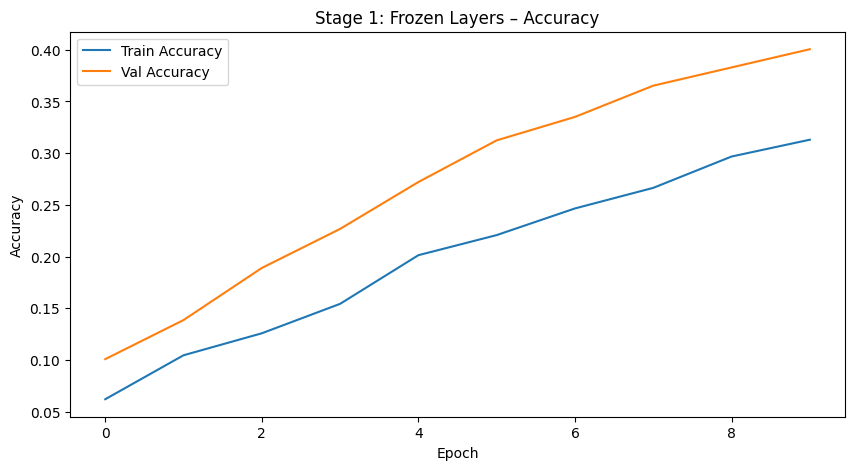

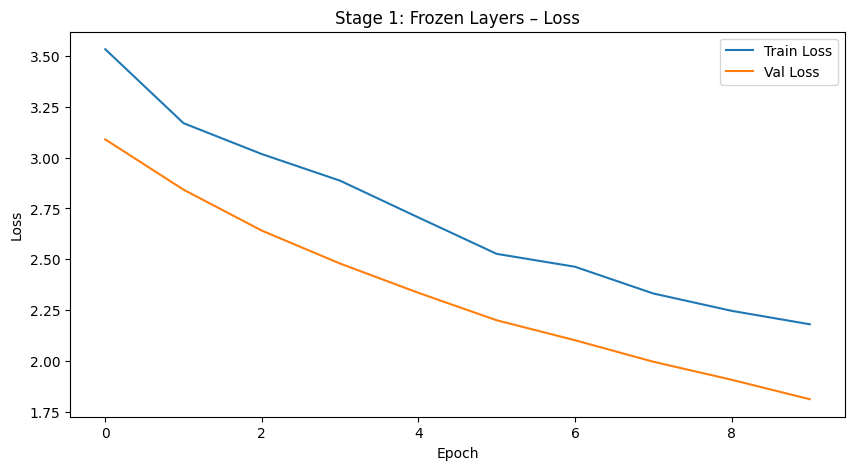

In [26]:
# --- TRAINING (FROZEN LAYERS) CURVES ---
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Stage 1: Frozen Layers – Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Stage 1: Frozen Layers – Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


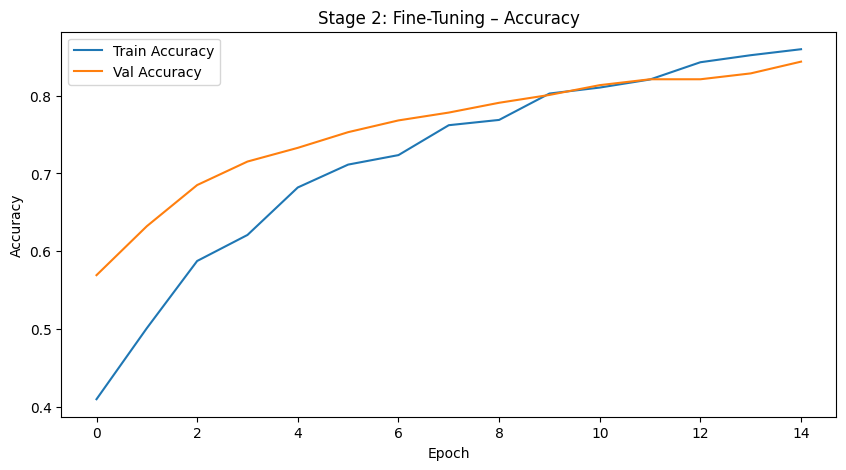

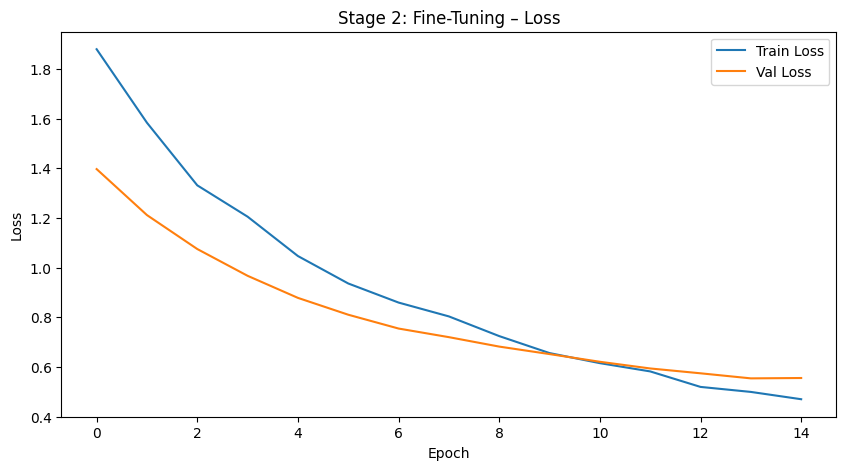

In [27]:
# --- FINE-TUNING CURVES ---
plt.figure(figsize=(10,5))
plt.plot(fine_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Stage 2: Fine-Tuning – Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(fine_history.history['loss'], label='Train Loss')
plt.plot(fine_history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Stage 2: Fine-Tuning – Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 382ms/step


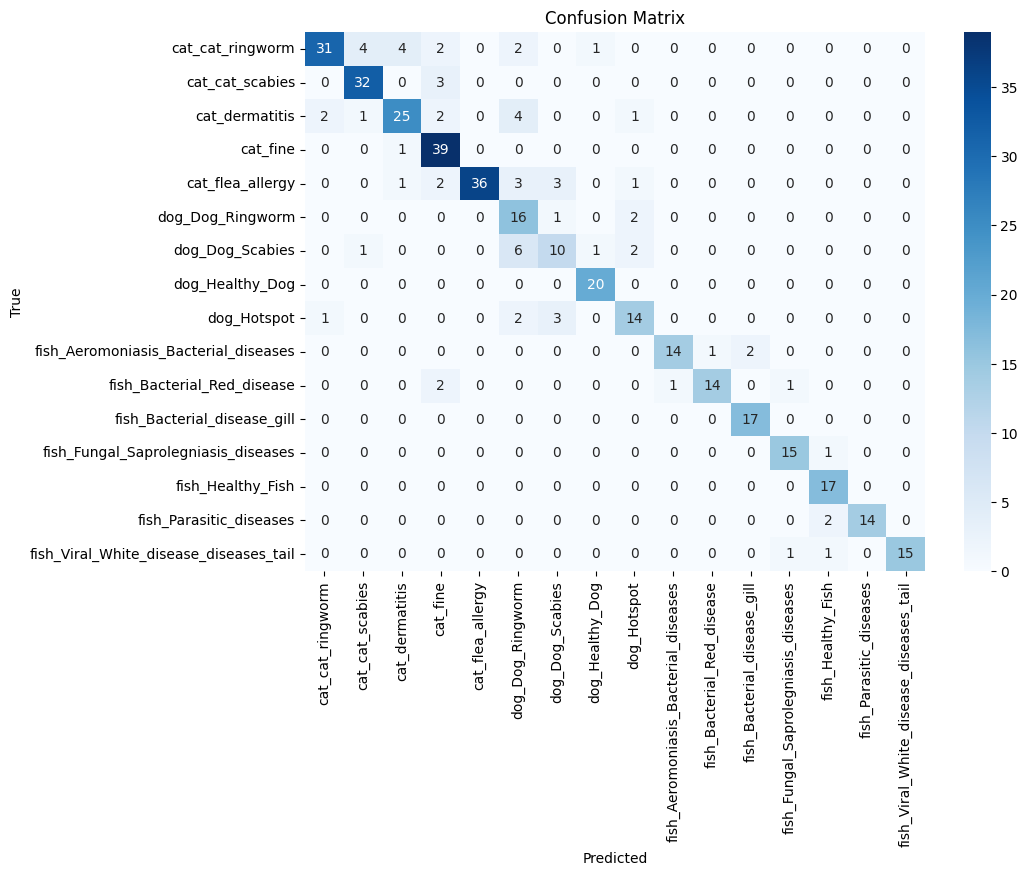


Classification Report:

                                        precision    recall  f1-score   support

                      cat_cat_ringworm       0.91      0.70      0.79        44
                       cat_cat_scabies       0.84      0.91      0.88        35
                        cat_dermatitis       0.81      0.71      0.76        35
                              cat_fine       0.78      0.97      0.87        40
                      cat_flea_allergy       1.00      0.78      0.88        46
                      dog_Dog_Ringworm       0.48      0.84      0.62        19
                       dog_Dog_Scabies       0.59      0.50      0.54        20
                       dog_Healthy_Dog       0.91      1.00      0.95        20
                           dog_Hotspot       0.70      0.70      0.70        20
  fish_Aeromoniasis_Bacterial_diseases       0.93      0.82      0.87        17
            fish_Bacterial_Red_disease       0.93      0.78      0.85        18
           fis

In [23]:
# 11. Final Evaluation
preds = model.predict(val_generator)
predicted_classes = np.argmax(preds, axis=1)
true_classes = val_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=labels))

In [4]:
import tensorflow as tf
import os

# Your SavedModel is at this path
model_path = '/kaggle/input/animal/keras/default/1'

# Check what's in the directory
print("Contents of model directory:")
for root, dirs, files in os.walk(model_path):
    level = root.replace(model_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        print(f'{subindent}{file}')

# Load the SavedModel
model = tf.keras.models.load_model(model_path)
print("\n✓ Model loaded successfully!")

# Check model details
print(f"\nModel type: {type(model)}")
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")
print(f"Number of layers: {len(model.layers)}")

# Optional: Show model architecture
model.summary()

Contents of model directory:
1/
  final_resnet50_animal_disease (2).keras


ValueError: File format not supported: filepath=/kaggle/input/animal/keras/default/1. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(/kaggle/input/animal/keras/default/1, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [3]:
import tensorflow as tf
from tensorflow import keras

# Your model files are in /kaggle/input/[dataset-name]/
dataset_name = "/kaggle/input/animal/keras/default/1"  # Replace with your actual dataset name

# List files in the dataset
import os
input_path = '/kaggle/input/' + dataset_name.split('/')[-1]  # Gets the dataset name part
print("Available files:")
for file in os.listdir(input_path):
    print(f"  - {file}")

# Load your model
# Find the exact filename from above
model = keras.models.load_model(f'{input_path}/your_model_filename.keras')
print("Model loaded successfully!")

Available files:


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/1'

In [24]:
# ===============================
# Gradio UI for Disease Prediction
# ===============================

import gradio as gr
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the saved model
model = tf.keras.models.load_model("final_resnet50_animal_disease.keras")

# Class labels from generator
labels = list(train_generator.class_indices.keys())

def predict_image(image):
    # Preprocessing
    img = image.resize((224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Prediction
    preds = model.predict(img_array)
    confidence = np.max(preds)
    pred_class = labels[np.argmax(preds)]

    return {
        "Prediction": pred_class,
        "Confidence": f"{confidence*100:.2f}%"
    }

# Gradio Interface
demo = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.JSON(label="Model Output"),
    title="🐾 Animal Disease Detector using ResNet50",
    description="Upload an animal image to classify disease"
)

demo.launch(debug=True)  # For Kaggle use (share=False automatically)


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://1317a02923b6401193.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1317a02923b6401193.gradio.live
